In [1]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.special import softmax
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import optuna
from collections import Counter
from transformers import EarlyStoppingCallback

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Load dataset
file_path = "2_processed_data/labelled_dataset_revised.csv"
df = pd.read_csv(file_path, encoding="latin1")

valid_labels = ['C', 'G', 'W/Q', 'OTH']
df = df[df['revised_argument_type'].isin(valid_labels)].copy()

label_map = {label: i for i, label in enumerate(valid_labels)}
inv_label_map = {i: label for label, i in label_map.items()}
df['label'] = df['revised_argument_type'].map(label_map).astype(int)

In [6]:
# Stratified Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['sentence'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

In [7]:
# Tokenizer and Model
model_ckpt = "gpt2"

tokenizer = GPT2Tokenizer.from_pretrained(model_ckpt)
tokenizer.pad_token = tokenizer.eos_token

model = GPT2ForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=len(valid_labels),
    pad_token_id=tokenizer.eos_token_id
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Define tokenization function
def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256,
        return_tensors=None
    )

# Create Hugging Face Dataset objects
train_ds = Dataset.from_dict({
    "text": train_texts,
    "label": train_labels
}).map(tokenize, batched=True)

val_ds = Dataset.from_dict({
    "text": val_texts,
    "label": val_labels
}).map(tokenize, batched=True)

Map: 100%|██████████| 21707/21707 [00:04<00:00, 5381.30 examples/s]


In [9]:
# Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="model/gpt2/results",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,

    learning_rate=2e-5,
    weight_decay=0.05,
    num_train_epochs=2,

    fp16=torch.cuda.is_available(),

    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    dataloader_prefetch_factor=2,

    logging_dir="model/gpt2/logs",
    logging_steps=100,
    save_total_limit=2
)

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)


C:\Users\user\AppData\Local\Temp\ipykernel_13720\1119399628.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.337200,0.319536,0.875386,0.851450
2,0.321100,0.289336,0.891325,0.866467


TrainOutput(global_step=10854, training_loss=0.3697683874889041, metrics={'train_runtime': 4952.8026, 'train_samples_per_second': 35.061, 'train_steps_per_second': 2.191, 'total_flos': 2.26875000619008e+16, 'train_loss': 0.3697683874889041, 'epoch': 2.0})


=== Classification Report ===
              precision    recall  f1-score   support

           C       0.84      0.92      0.88      3388
           G       0.90      0.91      0.91      5736
         W/Q       0.94      0.91      0.92      9830
         OTH       0.77      0.74      0.75      2753

    accuracy                           0.89     21707
   macro avg       0.86      0.87      0.87     21707
weighted avg       0.89      0.89      0.89     21707

Confusion Matrix:
 [[3122   42  101  123]
 [  93 5238  229  176]
 [ 275  287 8946  322]
 [ 214  247  250 2042]]


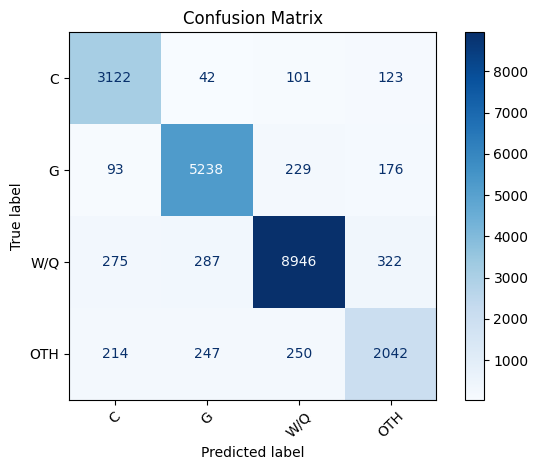

In [ ]:
# Run predictions
preds = trainer.predict(val_ds)
y_pred = np.argmax(preds.predictions, axis=1)

# Classification Report
print("\n=== Classification Report ===")
labels_present = sorted(set(val_labels))
target_names_present = [inv_label_map[i] for i in labels_present]

print(classification_report(
    val_labels,
    y_pred,
    labels=labels_present,
    target_names=target_names_present,
    zero_division=0
))

# Confusion Matrix
y_true = val_labels
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Plot as heatmap
labels_order = [inv_label_map[i] for i in range(len(inv_label_map))]  # ['C', 'G', 'W/Q', 'OTH']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_order)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


=== ROC AUCs ===
C: AUC = 0.9906
G: AUC = 0.9893
W/Q: AUC = 0.9838
OTH: AUC = 0.9706
Micro-average AUC: 0.9863
Macro-average AUC: 0.9836


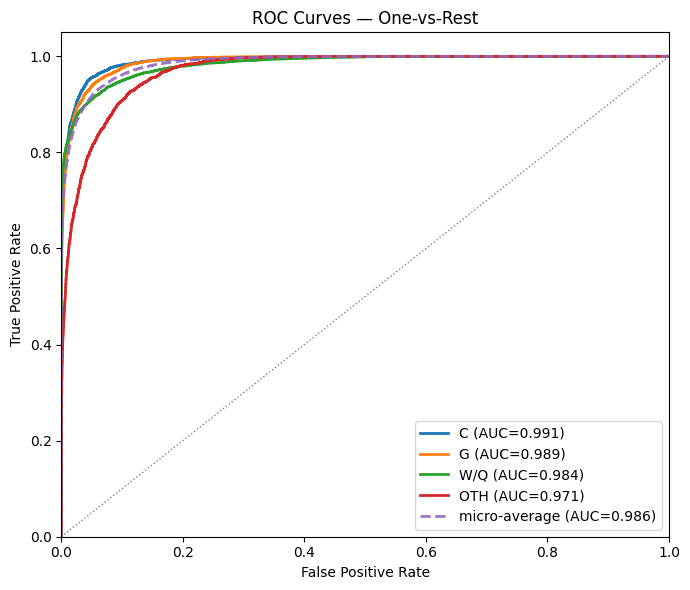

In [ ]:
# ROC / AUC (one-vs-rest)
# Get class probabilities from logits
probs_all = softmax(preds.predictions, axis=1)

# Classes actually present in the validation labels (avoids ROC errors if a class is missing)
labels_present = sorted(set(y_true))
class_names_present = [inv_label_map[i] for i in labels_present]

# Binarize true labels
y_true_bin = label_binarize(np.array(y_true), classes=labels_present)

# Align probs to the present classes (columns are class indices)
probs = probs_all[:, labels_present]

# Compute per-class ROC and AUC
fprs, tprs, aucs = {}, {}, {}
for j, cls_id in enumerate(labels_present):
    # Skip if no positive samples for this class in y_true
    if y_true_bin[:, j].sum() == 0:
        continue
    fpr, tpr, _ = roc_curve(y_true_bin[:, j], probs[:, j])
    fprs[cls_id], tprs[cls_id] = fpr, tpr
    aucs[cls_id] = auc(fpr, tpr)

# Micro-average ROC/AUC
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), probs.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average AUC (mean across available per-class AUCs)
auc_macro = float(np.mean(list(aucs.values()))) if len(aucs) > 0 else float("nan")

# Print AUCs
print("\n=== ROC AUCs ===")
for cls_id in labels_present:
    name = inv_label_map[cls_id]
    if cls_id in aucs:
        print(f"{name}: AUC = {aucs[cls_id]:.4f}")
    else:
        print(f"{name}: AUC = N/A (no positive examples)")
print(f"Micro-average AUC: {auc_micro:.4f}")
print(f"Macro-average AUC: {auc_macro:.4f}")

# Plot ROC curves
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 6))
# Per-class curves
for cls_id in labels_present:
    if cls_id in fprs:
        plt.plot(fprs[cls_id], tprs[cls_id], lw=2,
                 label=f"{inv_label_map[cls_id]} (AUC={aucs[cls_id]:.3f})")

# Micro-average
plt.plot(fpr_micro, tpr_micro, lw=2, linestyle="--",
         label=f"micro-average (AUC={auc_micro:.3f})", alpha=0.9)

# Chance line
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle=":")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — One-vs-Rest")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [ ]:
# Save model
model.save_pretrained("3_model/gpt2")
tokenizer.save_pretrained("3_model/gpt2")

('gpt2\\tokenizer_config.json',
 'gpt2\\special_tokens_map.json',
 'gpt2\\vocab.json',
 'gpt2\\merges.txt',
 'gpt2\\added_tokens.json')

In [12]:
# --- detect debate/filename column & sample 40 debates ---
filename_col = None
for cand in ["filename", "file_name", "debate_id", "doc", "source", "file", "topic_id"]:
    if cand in df.columns:
        filename_col = cand
        break
if filename_col is None:
    raise ValueError("Please ensure your dataset has a column with debate/filename IDs")

unique_files = df[filename_col].dropna().unique().tolist()
rng = np.random.default_rng(42)
sampled_files = rng.choice(unique_files, size=min(100, len(unique_files)), replace=False).tolist()
df_sample = df[df[filename_col].isin(sampled_files)].copy()

In [13]:
print("\n=== SAMPLING SUMMARY ===")
print(f"Identifier column: {filename_col}")
print(f"Unique debates total: {len(unique_files)}")
print(f"Sampled debates: {len(sampled_files)}")
print(f"Sampled rows: {len(df_sample)}")
print("Sample label counts:", Counter(df_sample["label"]))


=== SAMPLING SUMMARY ===
Identifier column: filename
Unique debates total: 3738
Sampled debates: 100
Sampled rows: 2931
Sample label counts: Counter({2: 1251, 1: 870, 0: 458, 3: 352})


In [14]:
# --- split sampled subset ---
train_texts_s, val_texts_s, train_labels_s, val_labels_s = train_test_split(
    df_sample["sentence"].tolist(),
    df_sample["label"].tolist(),
    test_size=0.2,
    stratify=df_sample["label"],
    random_state=42
)

In [15]:
print("\n=== SAMPLED SPLIT SHAPES ===")
print(f"train_texts: {len(train_texts_s)} | val_texts: {len(val_texts_s)}")
print("Train class balance:", Counter(train_labels_s))
print("Val class balance:", Counter(val_labels_s))


=== SAMPLED SPLIT SHAPES ===
train_texts: 2344 | val_texts: 587
Train class balance: Counter({2: 1000, 1: 696, 0: 366, 3: 282})
Val class balance: Counter({2: 251, 1: 174, 0: 92, 3: 70})


In [16]:
# helper to create datasets
def make_hf_datasets(texts_train, labels_train, texts_val, labels_val, max_length=256):
    train_ds = Dataset.from_dict({"text": texts_train, "label": labels_train})
    val_ds   = Dataset.from_dict({"text": texts_val,   "label": labels_val})
    def tokenize(batch):
        return tokenizer(
            batch["text"], padding="max_length", truncation=True,
            max_length=max_length, return_tensors=None
        )
    train_ds = train_ds.map(tokenize, batched=True)
    val_ds   = val_ds.map(tokenize, batched=True)
    return train_ds, val_ds

In [19]:
# helper to create datasets
def make_hf_datasets(texts_train, labels_train, texts_val, labels_val, max_length=256):
    train_ds = Dataset.from_dict({"text": texts_train, "label": labels_train})
    val_ds   = Dataset.from_dict({"text": texts_val,   "label": labels_val})
    def tokenize(batch):
        return tokenizer(
            batch["text"], padding="max_length", truncation=True,
            max_length=max_length, return_tensors=None
        )
    train_ds = train_ds.map(tokenize, batched=True)
    val_ds   = val_ds.map(tokenize, batched=True)
    return train_ds, val_ds

# --- objective for Optuna ---
def objective(trial):
    lr = trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    batch_size = trial.suggest_categorical("per_device_train_batch_size", [8, 16])
    grad_accum = trial.suggest_categorical("gradient_accumulation_steps", [1, 2, 4])
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.15)
    max_length = trial.suggest_categorical("max_length", [128, 256, 384])
    num_epochs = trial.suggest_categorical("num_train_epochs", [1, 2])

    train_ds_s, val_ds_s = make_hf_datasets(train_texts_s, train_labels_s,
                                            val_texts_s, val_labels_s,
                                            max_length=max_length)

    model_hpo = GPT2ForSequenceClassification.from_pretrained(
        model_ckpt,
        num_labels=len(valid_labels),
        pad_token_id=tokenizer.eos_token_id
    )

    args = TrainingArguments(
        output_dir=f"model/gpt2/hpo_trial_{trial.number}",
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,

        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=min(batch_size, 32),
        gradient_accumulation_steps=grad_accum,

        learning_rate=lr,
        weight_decay=weight_decay,
        num_train_epochs=num_epochs,
        warmup_ratio=warmup_ratio,

        fp16=torch.cuda.is_available(),
        logging_steps=50,
        save_total_limit=1,
        report_to=[]
    )

    trainer_hpo = Trainer(
        model=model_hpo,
        args=args,
        tokenizer=tokenizer,
        train_dataset=train_ds_s,
        eval_dataset=val_ds_s,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer_hpo.train()
    eval_res = trainer_hpo.evaluate(val_ds_s)
    return eval_res["eval_f1_macro"]

In [20]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, show_progress_bar=False)

[I 2025-09-06 00:01:47,104] A new study created in memory with name: no-name-ff097a48-6cd8-4ce3-8130-7251e7992fed
Map: 100%|██████████| 587/587 [00:00<00:00, 4372.20 examples/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_49860\3203140391.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.695900,1.090111,0.483816,0.373002


[I 2025-09-06 00:02:25,985] Trial 0 finished with value: 0.37300194138579446 and parameters: {'learning_rate': 3.047944796155913e-05, 'weight_decay': 0.035037826137339925, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 4, 'warmup_ratio': 0.04419846862756836, 'max_length': 128, 'num_train_epochs': 1}. Best is trial 0 with value: 0.37300194138579446.
Map: 100%|██████████| 587/587 [00:00<00:00, 4141.01 examples/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_49860\3203140391.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.488560,0.187394,0.141103


[I 2025-09-06 00:03:02,274] Trial 1 finished with value: 0.14110336324456813 and parameters: {'learning_rate': 1.1953338238375363e-05, 'weight_decay': 0.0019238362394572884, 'per_device_train_batch_size': 16, 'gradient_accumulation_steps': 4, 'warmup_ratio': 0.07848615292325628, 'max_length': 128, 'num_train_epochs': 1}. Best is trial 0 with value: 0.37300194138579446.
Map: 100%|██████████| 587/587 [00:00<00:00, 3958.28 examples/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_49860\3203140391.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class inste

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.110856,0.492334,0.426724


[I 2025-09-06 00:05:04,669] Trial 2 finished with value: 0.4267241092241092 and parameters: {'learning_rate': 0.0004443217890082942, 'weight_decay': 0.017280055499107095, 'per_device_train_batch_size': 16, 'gradient_accumulation_steps': 4, 'warmup_ratio': 0.10973637229191119, 'max_length': 256, 'num_train_epochs': 1}. Best is trial 2 with value: 0.4267241092241092.
Map: 100%|██████████| 587/587 [00:00<00:00, 3733.74 examples/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_49860\3203140391.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.856600,0.694056,0.708688,0.675549


[I 2025-09-06 00:06:30,980] Trial 3 finished with value: 0.675548981759988 and parameters: {'learning_rate': 9.654502322046035e-05, 'weight_decay': 0.0550346844165586, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 1, 'warmup_ratio': 0.0006336383694570457, 'max_length': 256, 'num_train_epochs': 1}. Best is trial 3 with value: 0.675548981759988.
Map: 100%|██████████| 587/587 [00:00<00:00, 3378.53 examples/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_49860\3203140391.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,2.339200,1.167844,0.456559,0.365834
2,1.182700,1.119499,0.482112,0.448826


[I 2025-09-06 00:09:43,815] Trial 4 finished with value: 0.44882585426348426 and parameters: {'learning_rate': 1.3005227860294562e-05, 'weight_decay': 0.06972513229818948, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 4, 'warmup_ratio': 0.00802382114564395, 'max_length': 384, 'num_train_epochs': 2}. Best is trial 3 with value: 0.675548981759988.
Map: 100%|██████████| 587/587 [00:00<00:00, 3345.07 examples/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_49860\3203140391.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.658900,1.049984,0.521295,0.476160


[I 2025-09-06 00:11:25,944] Trial 5 finished with value: 0.4761598847559477 and parameters: {'learning_rate': 4.99216222685368e-05, 'weight_decay': 0.07238167085295082, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 4, 'warmup_ratio': 0.14762594286011838, 'max_length': 384, 'num_train_epochs': 1}. Best is trial 3 with value: 0.675548981759988.
Map: 100%|██████████| 587/587 [00:00<00:00, 3799.35 examples/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_49860\3203140391.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,2.361700,1.160982,0.420784,0.401204
2,1.126300,1.072976,0.504259,0.493542


[I 2025-09-06 00:12:35,352] Trial 6 finished with value: 0.4935421180846717 and parameters: {'learning_rate': 2.759064792483839e-05, 'weight_decay': 0.0841957972412839, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 4, 'warmup_ratio': 0.08805813015549584, 'max_length': 128, 'num_train_epochs': 2}. Best is trial 3 with value: 0.675548981759988.
Map: 100%|██████████| 587/587 [00:00<00:00, 3279.93 examples/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_49860\3203140391.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.883900,0.744408,0.681431,0.581702
2,0.438200,0.579872,0.792164,0.752698


[I 2025-09-06 00:16:17,681] Trial 7 finished with value: 0.7526977360185075 and parameters: {'learning_rate': 0.0004995774303482198, 'weight_decay': 0.0346647373223764, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 1, 'warmup_ratio': 0.053645456647558466, 'max_length': 384, 'num_train_epochs': 2}. Best is trial 7 with value: 0.7526977360185075.
Map: 100%|██████████| 587/587 [00:00<00:00, 3851.65 examples/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_49860\3203140391.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.088826,0.517888,0.494735


[I 2025-09-06 00:16:54,468] Trial 8 finished with value: 0.4947352294270153 and parameters: {'learning_rate': 7.770216501780681e-05, 'weight_decay': 0.0726908741610945, 'per_device_train_batch_size': 16, 'gradient_accumulation_steps': 4, 'warmup_ratio': 0.026670721340862385, 'max_length': 128, 'num_train_epochs': 1}. Best is trial 7 with value: 0.7526977360185075.
Map: 100%|██████████| 587/587 [00:00<00:00, 3597.76 examples/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_49860\3203140391.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,2.640100,1.235818,0.374787,0.338809


[I 2025-09-06 00:18:04,536] Trial 9 finished with value: 0.33880916321904 and parameters: {'learning_rate': 1.0164548127336332e-05, 'weight_decay': 0.025170859901744193, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 4, 'warmup_ratio': 0.07930826725942687, 'max_length': 256, 'num_train_epochs': 1}. Best is trial 7 with value: 0.7526977360185075.


In [21]:
print("\n=== HPO BEST TRIAL ===")
print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)


=== HPO BEST TRIAL ===
Best f1_macro: 0.7526977360185075
Best params: {'learning_rate': 0.0004995774303482198, 'weight_decay': 0.0346647373223764, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 1, 'warmup_ratio': 0.053645456647558466, 'max_length': 384, 'num_train_epochs': 2}


In [22]:
best_params = study.best_params.copy()
best_max_length = best_params.pop("max_length", 256)
_ = best_params.pop("num_train_epochs", None)

In [23]:
# --- split FULL dataset ---
train_texts_full, val_texts_full, train_labels_full, val_labels_full = train_test_split(
    df["sentence"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

In [24]:
print("\n=== FULL SPLIT SHAPES ===")
print(f"train_texts_full: {len(train_texts_full)} | val_texts_full: {len(val_texts_full)}")
print("Train balance (full):", Counter(train_labels_full))
print("Val balance (full):", Counter(val_labels_full))


=== FULL SPLIT SHAPES ===
train_texts_full: 86825 | val_texts_full: 21707
Train balance (full): Counter({2: 39319, 1: 22944, 0: 13552, 3: 11010})
Val balance (full): Counter({2: 9830, 1: 5736, 0: 3388, 3: 2753})


In [25]:
train_ds_full, val_ds_full = make_hf_datasets(train_texts_full, train_labels_full,
                                              val_texts_full, val_labels_full,
                                              max_length=best_max_length)

Map: 100%|██████████| 21707/21707 [00:04<00:00, 4356.20 examples/s]


In [26]:
final_epochs = 3

model_final = GPT2ForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=len(valid_labels),
    pad_token_id=tokenizer.eos_token_id
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
final_args = TrainingArguments(
    output_dir="model/gpt2/final_best",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    per_device_train_batch_size=best_params.get("per_device_train_batch_size", 8),
    per_device_eval_batch_size=min(best_params.get("per_device_train_batch_size", 8), 32),
    gradient_accumulation_steps=best_params.get("gradient_accumulation_steps", 2),
    learning_rate=best_params.get("learning_rate", 2e-5),
    weight_decay=best_params.get("weight_decay", 0.05),
    warmup_ratio=best_params.get("warmup_ratio", 0.0),

    num_train_epochs=final_epochs,
    fp16=torch.cuda.is_available(),
    logging_dir="model/gpt2/final_best/logs",
    logging_steps=100,
    save_total_limit=2,
    report_to=[]
)

In [28]:
trainer_final = Trainer(
    model=model_final,
    args=final_args,
    tokenizer=tokenizer,
    train_dataset=train_ds_full,
    eval_dataset=val_ds_full,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

C:\Users\user\AppData\Local\Temp\ipykernel_49860\2712664601.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_final = Trainer(


In [29]:

trainer_final.train()

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.403100,0.431956,0.842493,0.805484
2,0.310900,0.417319,0.855669,0.824405
3,0.251100,0.459271,0.859907,0.828359


TrainOutput(global_step=32562, training_loss=0.38410411798634037, metrics={'train_runtime': 11643.5354, 'train_samples_per_second': 22.371, 'train_steps_per_second': 2.797, 'total_flos': 5.10468751392768e+16, 'train_loss': 0.38410411798634037, 'epoch': 3.0})

In [30]:
# --- evaluation on full val set ---
preds_full = trainer_final.predict(val_ds_full)
y_pred_full = np.argmax(preds_full.predictions, axis=1)
y_true_full = np.array(val_labels_full)

print("\n=== FINAL CLASSIFICATION REPORT ===")
print(classification_report(
    y_true_full,
    y_pred_full,
    labels=sorted(set(y_true_full)),
    target_names=[inv_label_map[i] for i in sorted(set(y_true_full))],
    zero_division=0
))


=== FINAL CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           C       0.85      0.85      0.85      3388
           G       0.85      0.88      0.86      5736
         W/Q       0.91      0.91      0.91      9830
         OTH       0.72      0.67      0.69      2753

    accuracy                           0.86     21707
   macro avg       0.83      0.83      0.83     21707
weighted avg       0.86      0.86      0.86     21707



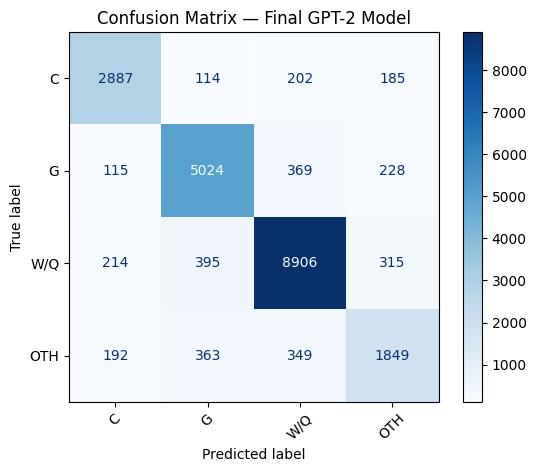

In [31]:
cm_full = confusion_matrix(y_true_full, y_pred_full)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_full,
                               display_labels=[inv_label_map[i] for i in range(len(inv_label_map))])
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix — Final GPT-2 Model")
plt.show()


=== ROC AUCs (Final Val) ===
C: AUC = 0.9820
G: AUC = 0.9790
W/Q: AUC = 0.9771
OTH: AUC = 0.9538
Micro-average AUC: 0.9776
Macro-average AUC: 0.9730


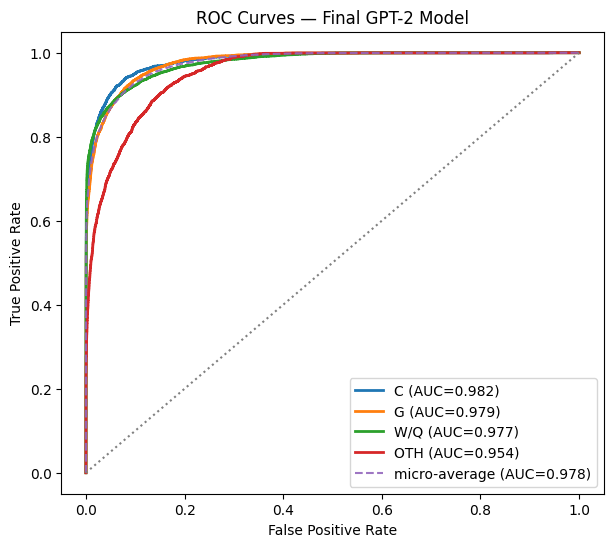

In [32]:
# --- ROC / AUC ---
probs_all_full = softmax(preds_full.predictions, axis=1)
labels_present = sorted(set(y_true_full))
y_true_bin_full = label_binarize(y_true_full, classes=labels_present)
probs_aligned = probs_all_full[:, labels_present]

fprs, tprs, aucs = {}, {}, {}
for j, cls_id in enumerate(labels_present):
    if y_true_bin_full[:, j].sum() == 0:
        continue
    fpr, tpr, _ = roc_curve(y_true_bin_full[:, j], probs_aligned[:, j])
    fprs[cls_id], tprs[cls_id] = fpr, tpr
    aucs[cls_id] = auc(fpr, tpr)

fpr_micro, tpr_micro, _ = roc_curve(y_true_bin_full.ravel(), probs_aligned.ravel())
auc_micro = auc(fpr_micro, tpr_micro)
auc_macro = float(np.mean(list(aucs.values()))) if len(aucs) > 0 else float("nan")

print("\n=== ROC AUCs (Final Val) ===")
for cls_id in labels_present:
    print(f"{inv_label_map[cls_id]}: AUC = {aucs.get(cls_id, float('nan')):.4f}")
print(f"Micro-average AUC: {auc_micro:.4f}")
print(f"Macro-average AUC: {auc_macro:.4f}")

plt.figure(figsize=(7, 6))
for cls_id in labels_present:
    if cls_id in fprs:
        plt.plot(fprs[cls_id], tprs[cls_id], lw=2,
                 label=f"{inv_label_map[cls_id]} (AUC={aucs[cls_id]:.3f})")
plt.plot(fpr_micro, tpr_micro, linestyle="--",
         label=f"micro-average (AUC={auc_micro:.3f})", alpha=0.9)
plt.plot([0, 1], [0, 1], linestyle=":", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Final GPT-2 Model")
plt.legend(loc="lower right")
plt.show()

In [33]:
# --- save final model ---
save_dir = "3_model/gpt2-best"
model_final.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
print(f"\nSaved final best GPT-2 model to: {save_dir}")
print("Best HPO params used:", {**best_params, "max_length": best_max_length, "final_epochs": final_epochs})


Saved final best GPT-2 model to: 3_model/gpt2-best
Best HPO params used: {'learning_rate': 0.0004995774303482198, 'weight_decay': 0.0346647373223764, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 1, 'warmup_ratio': 0.053645456647558466, 'max_length': 384, 'final_epochs': 3}
